In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from common.utils import EvaluationMetrics, ActivationFunctions, AverageNormalizer2D
from models.linear_regression import LinearRegressionAnalytic
from models.logistic_regressions import LogisticRegression
from models.neural_networks import *
from models.support_vector import SVM

In [2]:
def calculate_classification_metrics(yhat, y):
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    if isinstance(yhat, pd.Series):
        yhat = yhat.to_numpy()

    accuracy = 100. * sum(yhat == y) / len(y)

    true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0
    for i, _ in enumerate(y):
        if y[i] == 1:
            if yhat[i] == 1:
                true_positive += 1
            else:
                false_negative += 1
        else:
            if yhat[i] == 1:
                false_positive += 1
            else:
                true_negative += 1

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1


def print_classification_metrics(yhat, y):
    accuracy, precision, recall, f1 = calculate_classification_metrics(yhat, y)
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 = {f1}")

def calculate_regression_metrics(yhat, y):
    mae = np.mean((yhat - y) ** 2)
    rmse = np.sqrt(mae)

    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-yhat)**2).sum()
    r2 =  1 - (ss_res/ss_tot)
    return mae, rmse, r2

def print_regression_metrics(yhat, y):
    mae, rmse, r2 = calculate_regression_metrics(yhat, y)
    print(f"MAE = {mae}")
    print(f"RMSE = {rmse}")
    print(f"R2 = {r2}")

In [3]:
# Hackathon Set D

## Machine Learning Lab, SS 22, Uni Passau

### Rules:

# 1. You have time from 12 pm until 6 pm to complete the Hackathon task.
# 2. Submissions must be pushed to your gitlab in a folder dubbed `Hackathon`. Submissions are allowed until 6 pm.
# 3. Run your solutions in lines created under the individual questionnaire.
# 4. For model implementations you are permitted to use only your library in its final state before the commencement of the exam.


### Task 1: Prepare your data

   1. Download the two datasets and read them into memory.
   2.Analyse the data shape, targets and data characteristics.
   3.Apply any data cleaning, filling mechanisms if required
   4.Split the datasets into `train`, `valid` and `test` folds.

Dataset 1: [CLASSIFICATION] Mammographic Mass: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass

```python
!wget -P ./data/mammographic-mass/ https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data
!wget -P ./data/mammographic-mass/ https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.names
```
Dataset 2: [REGRESION] Computer Hardware Data Set:https://archive.ics.uci.edu/ml/datasets/Computer+Hardware




In [4]:
# with open("./mammographic/mammographic_masses.data") as file:
#     names = file.read()
print("loading mammographic dataset")
mammographic = pd.read_csv("./mammographic/mammographic_masses.data",
                           names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity'],
                           usecols=['Age', 'Shape', 'Margin', 'Density', 'Severity'], na_values='?')
nulls = mammographic.isnull().any(axis=1)
print("dropped ", sum(nulls), " null values")
mammographic = mammographic.dropna()
# predict the severity
mammographic

loading mammographic dataset
dropped  130  null values


,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


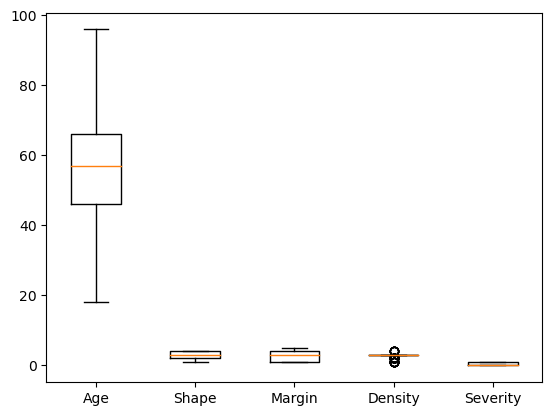

In [5]:
plt.figure()
plt.boxplot(mammographic)
plt.xticks(range(1, 6), ['Age', 'Shape', 'Margin', 'Density', 'Severity'])
plt.show()

In [6]:
mammographic_train_data = mammographic[:600]
mammographic_valid_data = mammographic[600:750]
mammographic_test_data = mammographic[750:]

mammographic_train_x = mammographic_train_data[mammographic_train_data.columns[:4]]
mammographic_train_y = mammographic_train_data[mammographic_train_data.columns[4]]

mammographic_valid_x = mammographic_valid_data[mammographic_valid_data.columns[:4]]
mammographic_valid_y = mammographic_valid_data[mammographic_valid_data.columns[4]]

mammographic_test_x = mammographic_test_data[mammographic_test_data.columns[:4]]
mammographic_test_y = mammographic_test_data[mammographic_test_data.columns[4]]

In [7]:
feature_normalizer = AverageNormalizer2D()
target_normalizer = AverageNormalizer2D()

feature_normalizer.calculate(mammographic_train_x.to_numpy())
target_normalizer.calculate(mammographic_train_y.to_numpy())

mammographic_train_x2 = feature_normalizer.normalize(mammographic_train_x.to_numpy())
mammographic_train_y2 = target_normalizer.normalize(mammographic_train_y.to_numpy())

mammographic_valid_x2 = feature_normalizer.normalize(mammographic_valid_x.to_numpy())
mammographic_valid_y2 = target_normalizer.normalize(mammographic_valid_y.to_numpy())

mammographic_test_x2 = feature_normalizer.normalize(mammographic_test_x.to_numpy())
mammographic_test_y2 = target_normalizer.normalize(mammographic_test_y.to_numpy())

Plotting normalized train x


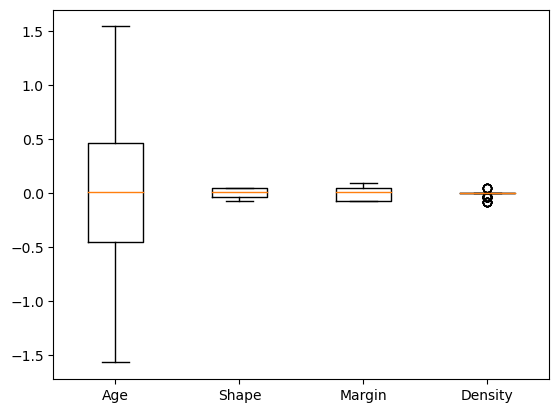

In [8]:
print("Plotting normalized train x")
plt.figure()
plt.boxplot(mammographic_train_x2)
plt.xticks(range(1, 5), ['Age', 'Shape', 'Margin', 'Density'])
plt.show()

In [9]:
# with open("./machines/machine.names") as file:
#     names = file.read()
print("loading machine dataset")
machines = pd.read_csv("./machines/machine.data",
                       names=['vendor_name', 'model_name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP',
                              'ERP'], usecols=['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP'])

# print(f"Found {len(machines['vendor_name'].unique())} unique values in vendor_name")
# machines['vendor_name'] = pd.factorize(machines['vendor_name'])[0]
machines
# predict the prp

loading machine dataset


,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,125,256,6000,256,16,128,198
1,29,8000,32000,32,8,32,269
2,29,8000,32000,32,8,32,220
3,29,8000,32000,32,8,32,172
4,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...
204,124,1000,8000,0,1,8,42
205,98,1000,8000,32,2,8,46
206,125,2000,8000,0,2,14,52
207,480,512,8000,32,0,0,67


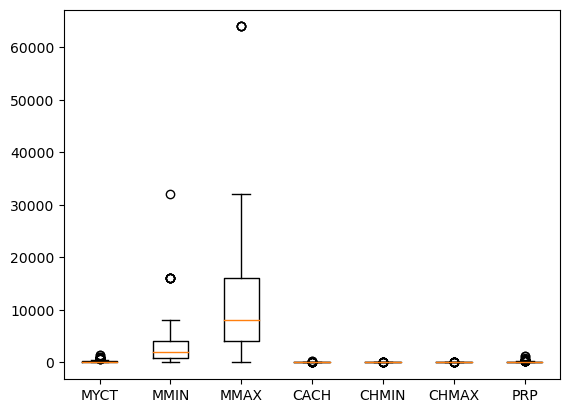

In [10]:
plt.figure()
plt.boxplot(machines)
plt.xticks(range(1, 8), ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP'])
plt.show()

In [11]:
machines_train_data = machines[:130]
machines_valid_data = machines[130:185]
machines_test_data = machines[185:]

machines_train_x = machines_train_data[machines_train_data.columns[:-1]]
machines_train_y = machines_train_data[machines_train_data.columns[-1]]

machines_valid_x = machines_valid_data[machines_valid_data.columns[:-1]]
machines_valid_y = machines_valid_data[machines_valid_data.columns[-1]]

machines_test_x = machines_test_data[machines_test_data.columns[:-1]]
machines_test_y = machines_test_data[machines_test_data.columns[-1]]

In [12]:
feature_normalizer2 = AverageNormalizer2D()
target_normalizer2 = AverageNormalizer2D()

feature_normalizer2.calculate(machines_train_x.to_numpy())
target_normalizer2.calculate(machines_train_y.to_numpy())

machines_train_x = feature_normalizer2.normalize(machines_train_x.to_numpy())
machines_train_y = target_normalizer2.normalize(machines_train_y.to_numpy())

machines_valid_x = feature_normalizer2.normalize(machines_valid_x.to_numpy())
machines_valid_y = target_normalizer2.normalize(machines_valid_y.to_numpy())

machines_test_x = feature_normalizer2.normalize(machines_test_x.to_numpy())
machines_test_y = target_normalizer2.normalize(machines_test_y.to_numpy())

Plotting normalized train x


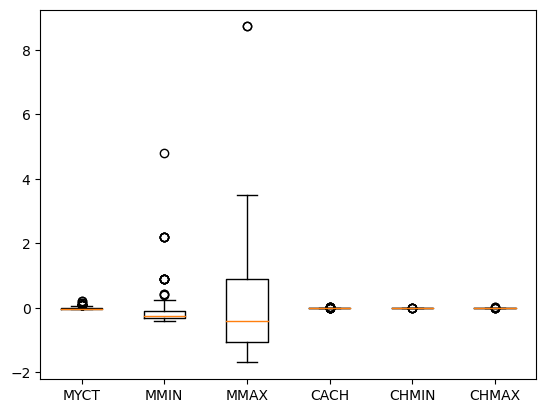

In [13]:
print("Plotting normalized train x")
plt.figure()
plt.boxplot(machines_train_x)
plt.xticks(range(1, 7), ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'])
plt.show()

### Task 2: Implement baseline model of your choice (1 classification + 1 regression) for each of the two datasets
```python
# baseline = YourAlgorithm()
# baseline.learn(features_train, labels_train)
```

In [14]:
print("Using Linear Classifier")
lr_analytic = LinearRegressionAnalytic()
# this model has internal feature normalizer, so we feed it the input before normalization
lr_analytic.learn(mammographic_train_x, mammographic_train_y)
predicted_analytic = lr_analytic.infer(mammographic_valid_x)
print("metrics for validation dataset")
print_classification_metrics(predicted_analytic.round(), mammographic_valid_y)

Using Linear Classifier
metrics for validation dataset
Accuracy = 84.66666666666667
Precision = 0.8082191780821918
Recall = 0.8676470588235294
F1 = 0.8368794326241135


In [15]:
print("Using SVM")

model = SVM(1)
model.learn(mammographic_train_x2, mammographic_train_y2)
# print_classification_metrics(predicted_analytic.round(), mammographic_valid_y)

def sign(value):
    return 0 if value <= 0 else 1.

predicted_analytic = []
for x in mammographic_valid_x2:
    predicted_analytic.append(sign(model.infer(x)))
print("metrics for validation dataset")
print_classification_metrics(predicted_analytic, mammographic_valid_y)

Using SVM
metrics for validation dataset
Accuracy = 72.0
Precision = 0.6547619047619048
Recall = 0.8088235294117647
F1 = 0.7236842105263157


#### Subtask 2

In [16]:
print("Using Linear Regression")

lr_analytic2 = LinearRegressionAnalytic()
lr_analytic2.learn(machines_train_x, machines_train_y)
predicted_analytic = lr_analytic2.infer(machines_valid_x)
print("metrics for validation dataset")
print_regression_metrics(predicted_analytic, machines_valid_y)

Using Linear Regression
metrics for validation dataset
MAE = 0.20470121983800013
RMSE = 0.45243918910501124
R2 = 0.6731996090916794


In [17]:
print("Using Logistic Regression")

lr_analytic4 = LogisticRegression()
lr_analytic4.learn(machines_train_x, machines_train_y)
predicted_analytic = lr_analytic4.infer(machines_valid_x)
print("metrics for validation dataset")
print_regression_metrics(predicted_analytic, machines_valid_y)

Using Logistic Regression
metrics for validation dataset
MAE = 1.6454454962030194
RMSE = 1.2827491945828768
R2 = -1.6269126867101318


### Task 3: Evaluate your baseline models on test set: 
Use accuracy, precision and recall for classification, and R2 score and MAE/RMSE for regression
```python
# baseline_predicted = model_baseline.infer(features_test)
# evaluate_fn(baseline_predicted, labels_test)
```

#### Subtask 1


In [18]:
print("Using Linear Classifier")

predicted_analytic = lr_analytic.infer(mammographic_test_x)
print("metrics for test dataset")
print_classification_metrics(predicted_analytic.round(), mammographic_test_y)

Using Linear Classifier
metrics for test dataset
Accuracy = 75.30864197530865
Precision = 0.7083333333333334
Recall = 0.85
F1 = 0.7727272727272727


In [19]:
print("Using SVM")

predicted_analytic = []
for x in mammographic_test_x2:
    predicted_analytic.append(sign(model.infer(x)))
print("metrics for validation dataset")
print_classification_metrics(predicted_analytic, mammographic_test_y)

Using SVM
metrics for validation dataset
Accuracy = 61.72839506172839
Precision = 0.6046511627906976
Recall = 0.65
F1 = 0.6265060240963854


#### Subtask 2

In [20]:
print("Using Linear Regression")

predicted_analytic = lr_analytic2.infer(machines_test_x)
print("metrics for test dataset")
print_regression_metrics(predicted_analytic, machines_test_y)

Using Linear Regression
metrics for test dataset
MAE = 1.6821842002025893
RMSE = 1.296990439518576
R2 = 0.5577345143553731


In [21]:
print("Using Logistic Regression")

predicted_analytic = lr_analytic4.infer(machines_test_x)
print("metrics for validation dataset")
print_regression_metrics(predicted_analytic, machines_test_y)

Using Logistic Regression
metrics for validation dataset
MAE = 5.205398357939447
RMSE = 2.281534211433054
R2 = -0.36855882516942984


### Task 4: Implement and train the following methods:

    a) Logistic Regression for classification 
    b) ANN for regression
    
- Use one fixed train-validation-test split consistently for all experiments
- Report the same metrics used for the baselines on the test set.

#### Subtask 1

In [22]:
lr_analytic3 = LogisticRegression()
lr_analytic3.learn(mammographic_train_x2, mammographic_train_y2, learning_rate=0.001, iterations=100)
predicted_analytic = lr_analytic3.infer(mammographic_valid_x2)
print("metrics for validation dataset")
print_classification_metrics(predicted_analytic.round(), mammographic_valid_y)

metrics for validation dataset
Accuracy = 81.33333333333333
Precision = 0.7564102564102564
Recall = 0.8676470588235294
F1 = 0.8082191780821918


In [23]:
predicted_analytic = lr_analytic3.infer(mammographic_test_x2)
print("metrics for test dataset")
print_classification_metrics(predicted_analytic.round(), mammographic_test_y)

metrics for test dataset
Accuracy = 71.60493827160494
Precision = 0.673469387755102
Recall = 0.825
F1 = 0.7415730337078652


#### Subtask 2

In [24]:
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

LEARNING_RATE = 0.001
LAMBDA = 1
EPOCHS = 10

def create_model(learning_rate, lambda_value, input_shape=6, hidden_layer1 = 10, hidden_layer2=20, hidden_layer3=10, output_shape=1):
    nn_model = NeuralNetworkModel()
    class Softmax(ActivationFunctionsForNN.BaseActivationFunctionForNN):
        def __init__(self):
            pass

        def forward(self, value):
            return np.exp(value) / np.sum(np.exp(value))

        def backward(self, value):
            return value


    layer0 = FlattenLayer()
    layer1 = LinearLayer(input_shape=input_shape, output_shape=hidden_layer1, learning_rate=learning_rate, lambda_regularization=lambda_value)
    layer2 = LinearLayer(input_shape=hidden_layer1, output_shape=hidden_layer2, learning_rate=learning_rate, lambda_regularization=lambda_value)
    layer3 = LinearLayer(input_shape=hidden_layer2, output_shape=hidden_layer3, learning_rate=learning_rate, lambda_regularization=lambda_value)
    layer4 = LinearLayer(input_shape=hidden_layer3, output_shape=output_shape, learning_rate=learning_rate, lambda_regularization=lambda_value, activation_function=Softmax())

    nn_model.add_layer(layer0)
    nn_model.add_layer(layer1)
    nn_model.add_layer(layer2)
    nn_model.add_layer(layer3)
    nn_model.add_layer(layer4)
    return nn_model

def predict_nn(features, nn_model):
    result = []
    for j in range(features.shape[0]):
        yhat = nn_model.infer(features[j])
        result.append(yhat)
    return result

nn = create_model(LEARNING_RATE, LAMBDA)
print(f'Number of parameters: {nn.get_number_of_parameters()}')
costs = nn.learn(machines_train_x, machines_train_y, EPOCHS, 20)

Number of parameters: 511
Cost at epoch 0 is 0.6006643354687662
Cost at epoch 1 is 0.6000893794646532
Cost at epoch 2 is 0.5995317133946062
Cost at epoch 3 is 0.5989907100313272
Cost at epoch 4 is 0.5984672774525893
Cost at epoch 5 is 0.5979603558094029
Cost at epoch 6 is 0.5974710539388026
Cost at epoch 7 is 0.5970000966260732
Cost at epoch 8 is 0.5965480436842797
Cost at epoch 9 is 0.5961154966908204


In [25]:
predicted_analytic = predict_nn(machines_valid_x, nn)
print("metrics for validation dataset")
print_regression_metrics(predicted_analytic, machines_valid_y)

metrics for validation dataset
MAE = 1.6138414316203407
RMSE = 1.270370588301044
R2 = -140.70516723067223


In [26]:
predicted_analytic = predict_nn(machines_test_x, nn)
print("metrics for test dataset")
print_regression_metrics(predicted_analytic, machines_test_y)

metrics for test dataset
MAE = 3.8529657025193607
RMSE = 1.9628972725334763
R2 = -23.311731103762767


### Task 5: Hyperparameter Optimisation
- For each of the models implemented in Task 4, conduct a grid search in reasonable ranges to find an appropriate set of hyperparameters, and justify the choice.

```python
# possible_hp_values = np.arange(1, 10, 0.1)
# best_hp_value = None
# best_f1_score = -np.infty
# for hp_value in possible_hp_values:
#     # 1. create a baseline classifier object with hp_value specified
#     current_model = YourAlgorithm(hyperparam=hp_value)
#
#     # 2. learn the classifier on the training set
#     current_model.learn(features_train, labels_train)
#
#     # 3. evaluate the model on the validation set
#     prediction = current_model.infer(features_valid)
#
#     f1_score = compute_f1(labels_valid, prediction)
#     if f1_score > best_f1_score:
#         best_f1_score = f1_score
#         best_hp_value = hp_value
#
# print("Found hyperparameter value", best_hp_value)
# print("Best f1-score on validation set", best_f1_score)
#
# test_model = YourAlgorithm(hyperparam=best_hp_value)
# test_model.learn(features_train, labels_train)
# prediction = test_model.infer(features_test)
# test_f1_score = compute_f1(labels_test, prediction)
# print("F1-Score on test set", test_f1_score)
```


#### Subtask 1

In [27]:
best_hyper_parameter= None
best_f1_score = -1
hyper_parameters = [[0.1, 5], [0.001, 100], [0.1, 100]]
for hyper_parameter in hyper_parameters:
    print("Running with the following hyper parameter: ",  hyper_parameter)
    lr_analytic3 = LogisticRegression()
    lr_analytic3.learn(mammographic_train_x2, mammographic_train_y2, learning_rate=hyper_parameter[0], iterations=hyper_parameter[1])
    predicted_analytic = lr_analytic3.infer(mammographic_valid_x2)
    _, _, _, f1 = calculate_classification_metrics(predicted_analytic.round(), mammographic_valid_y)
    print_classification_metrics(predicted_analytic.round(), mammographic_valid_y)
    print("")

    if f1 > best_f1_score:
        best_f1_score = f1
        best_hyper_parameter = hyper_parameter

print("Best hyper parameter is: ", best_hyper_parameter)
lr_analytic3 = LogisticRegression()
lr_analytic3.learn(mammographic_train_x2, mammographic_train_y2, learning_rate=best_hyper_parameter[0], iterations=best_hyper_parameter[1])
predicted_analytic = lr_analytic3.infer(mammographic_test_x2)
print_classification_metrics(predicted_analytic.round(), mammographic_test_y)

Running with the following hyper parameter:  [0.1, 5]
Accuracy = 38.0
Precision = 0.3076923076923077
Recall = 0.29411764705882354
F1 = 0.3007518796992481

Running with the following hyper parameter:  [0.001, 100]
Accuracy = 81.33333333333333
Precision = 0.7564102564102564
Recall = 0.8676470588235294
F1 = 0.8082191780821918

Running with the following hyper parameter:  [0.1, 100]
Accuracy = 30.0
Precision = 0.20634920634920634
Recall = 0.19117647058823528
F1 = 0.19847328244274806

Best hyper parameter is:  [0.001, 100]
Accuracy = 71.60493827160494
Precision = 0.673469387755102
Recall = 0.825
F1 = 0.7415730337078652


We can see that increasing the number of epochs and decreasing the learning rate improves the performance of the model

#### Subtask 2

In [28]:
best_hyper_parameter= None
best_rme_score = 100
hyper_parameters = [[0.1, 20, 10, 10, 10], [0.001, 20, 10, 10, 10], [0.1, 1, 10, 10, 10],
                    [0.001, 20, 5, 5, 5], [0.001, 20, 50, 50, 50], [0.1, 1, 5, 5, 5]]
for hyper_parameter in hyper_parameters:
    print("Running with the following hyper parameter: ",  hyper_parameter)
    nn = create_model(hyper_parameter[0], 1, hidden_layer1=hyper_parameter[2], hidden_layer2=hyper_parameter[3], hidden_layer3=hyper_parameter[4])
    costs = nn.learn(machines_train_x, machines_train_y, hyper_parameter[1], 20)

    predicted_analytic = predict_nn(machines_valid_x, nn)
    _, rme, _ = calculate_regression_metrics(predicted_analytic, machines_valid_y)
    print_regression_metrics(predicted_analytic, machines_valid_y)
    print("")

    if rme < best_rme_score:
        best_rme_score = rme
        best_hyper_parameter = hyper_parameter

nn = create_model(best_hyper_parameter[0], 1, hidden_layer1=best_hyper_parameter[2], hidden_layer2=best_hyper_parameter[3], hidden_layer3=best_hyper_parameter[4])
nn.learn(machines_train_x, machines_train_y, best_hyper_parameter[1], 20)

print("")
print("Best hyper parameter is: ", best_hyper_parameter)
predicted_analytic = predict_nn(machines_valid_x, nn)
print_regression_metrics(predicted_analytic, machines_valid_y)

Running with the following hyper parameter:  [0.1, 20, 10, 10, 10]
Cost at epoch 0 is 0.524872491504883
Cost at epoch 1 is nan
Cost at epoch 2 is nan
Cost at epoch 3 is nan


E:\miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Cost at epoch 4 is nan
Cost at epoch 5 is nan
Cost at epoch 6 is nan
Cost at epoch 7 is nan
Cost at epoch 8 is nan
Cost at epoch 9 is nan
Cost at epoch 10 is nan
Cost at epoch 11 is nan
Cost at epoch 12 is nan
Cost at epoch 13 is nan
Cost at epoch 14 is nan
Cost at epoch 15 is nan
Cost at epoch 16 is nan
Cost at epoch 17 is nan
Cost at epoch 18 is nan
Cost at epoch 19 is nan
MAE = nan
RMSE = nan
R2 = nan

Running with the following hyper parameter:  [0.001, 20, 10, 10, 10]
Cost at epoch 0 is 0.497118945161479
Cost at epoch 1 is 0.4967476478084968
Cost at epoch 2 is 0.4963812060652109
Cost at epoch 3 is 0.4960199822607839
Cost at epoch 4 is 0.49566424612659477
Cost at epoch 5 is 0.4953143198720839
Cost at epoch 6 is 0.49497017060158693
Cost at epoch 7 is 0.49463143780216606
Cost at epoch 8 is 0.4942989878731964
Cost at epoch 9 is 0.4939736398633077
Cost at epoch 10 is 0.49365573711579414
Cost at epoch 11 is 0.4933444308084038
Cost at epoch 12 is 0.493040376895457
Cost at epoch 13 is 0.4

We can see that increasing the number of epochs and decreasing the learning rate improves the performance of the model

We can also see that increasing dimension of hidden layers from 5 to 10 increases the performance but increasing it to 50 doesn't help as it greatly increases the number of parameters, and we don't have enough input to train the model

### Task 6: Statistical/stability tests

- over multiple runs $r \geq 5, r\in\mathbb{N}$  randomly shuffle your training data
- split it into a train-test, e.g. 90% of the data is for training, 10% for testing
- Report the mean and standard deviation of the error/accuracy of your models over the multiple runs
- plot a boxplot of the stability of your model

#### Subtask 1

mean is  74.69135802469135  and standard deviation is  2.882127785167593


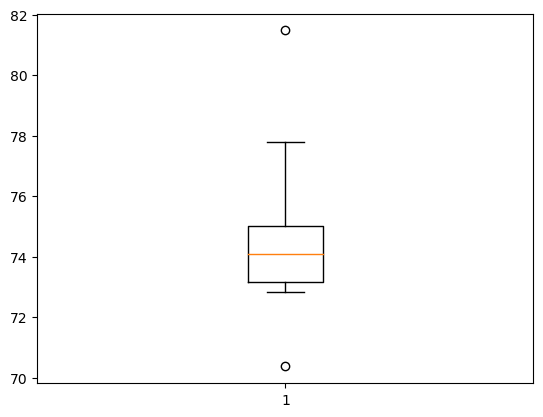

In [29]:
results = []
for i in range(10):
    temp = mammographic.sample(frac=1)

    mammographic_train_data = temp[:750]
    mammographic_test_data = temp[750:]

    mammographic_train_x = mammographic_train_data[mammographic_train_data.columns[:4]]
    mammographic_train_y = mammographic_train_data[mammographic_train_data.columns[4]]

    mammographic_test_x = mammographic_test_data[mammographic_test_data.columns[:4]]
    mammographic_test_y = mammographic_test_data[mammographic_test_data.columns[4]]

    feature_normalizer = AverageNormalizer2D()
    target_normalizer = AverageNormalizer2D()

    feature_normalizer.calculate(mammographic_train_x.to_numpy())
    target_normalizer.calculate(mammographic_train_y.to_numpy())

    mammographic_train_x2 = feature_normalizer.normalize(mammographic_train_x.to_numpy())
    mammographic_train_y2 = target_normalizer.normalize(mammographic_train_y.to_numpy())

    mammographic_test_x2 = feature_normalizer.normalize(mammographic_test_x.to_numpy())
    mammographic_test_y2 = target_normalizer.normalize(mammographic_test_y.to_numpy())

    lr_analytic3 = LogisticRegression()
    lr_analytic3.learn(mammographic_train_x2, mammographic_train_y2, learning_rate=0.001, iterations=100)
    predicted_analytic = lr_analytic3.infer(mammographic_test_x2)
    accuracy, _, _, _ = calculate_classification_metrics(predicted_analytic.round(), mammographic_test_y)
    results.append(accuracy)

print("mean is ", np.mean(results), " and standard deviation is ", np.std(results))

plt.figure()
plt.boxplot(results)
plt.show()

#### Subtask 2

In [30]:
results = []
for i in range(10):
    temp = machines.sample(frac=1)

    machines_train_data = temp[:180]
    machines_test_data = temp[180:]

    machines_train_x = machines_train_data[machines_train_data.columns[:-1]]
    machines_train_y = machines_train_data[machines_train_data.columns[-1]]

    machines_test_x = machines_test_data[machines_test_data.columns[:-1]]
    machines_test_y = machines_test_data[machines_test_data.columns[-1]]

    feature_normalizer2 = AverageNormalizer2D()
    target_normalizer2 = AverageNormalizer2D()

    feature_normalizer2.calculate(machines_train_x.to_numpy())
    target_normalizer2.calculate(machines_train_y.to_numpy())

    machines_train_x = feature_normalizer2.normalize(machines_train_x.to_numpy())
    machines_train_y = target_normalizer2.normalize(machines_train_y.to_numpy())

    machines_test_x = feature_normalizer2.normalize(machines_test_x.to_numpy())
    machines_test_y = target_normalizer2.normalize(machines_test_y.to_numpy())

    nn = create_model(learning_rate=0.001, lambda_value=1.0)
    costs = nn.learn(machines_train_x, machines_train_y, 10, 20)

    predicted_analytic = predict_nn(machines_valid_x, nn)
    _, rme, _ = calculate_regression_metrics(predicted_analytic, machines_valid_y)
    if str(rme) != "nan":
        results.append(rme)
    else:
        results.appen(10) # set rme to a big number (10) when training the model fails
    print_regression_metrics(predicted_analytic, machines_valid_y)

Cost at epoch 0 is 0.40634657576045696
Cost at epoch 1 is 0.4059097326769063
Cost at epoch 2 is 0.4054825445300398
Cost at epoch 3 is 0.4050670499271611
Cost at epoch 4 is 0.4046634500288865
Cost at epoch 5 is 0.40427249482560357
Cost at epoch 6 is 0.40389392084868236
Cost at epoch 7 is 0.4035278337832024
Cost at epoch 8 is 0.4031741622415322
Cost at epoch 9 is 0.4028334754182384
MAE = 1.6138414316203407
RMSE = 1.270370588301044
R2 = -140.70516723067223
Cost at epoch 0 is 0.5208178382623884
Cost at epoch 1 is 0.5205218761949404
Cost at epoch 2 is 0.520280426232883
Cost at epoch 3 is 0.5201014571478323
Cost at epoch 4 is 0.5199742426109718
Cost at epoch 5 is 0.5198792878122644
Cost at epoch 6 is 0.5198684488191168
Cost at epoch 7 is 0.5199157072093675
Cost at epoch 8 is 0.5199520117081
Cost at epoch 9 is 0.5200092930846151
MAE = 1.6138414316203407
RMSE = 1.270370588301044
R2 = -140.70516723067223
Cost at epoch 0 is 0.42496638300035144
Cost at epoch 1 is 0.4247100222222045
Cost at epoch 

mean is  1.2703705883010443  and standard deviation is  2.220446049250313e-16


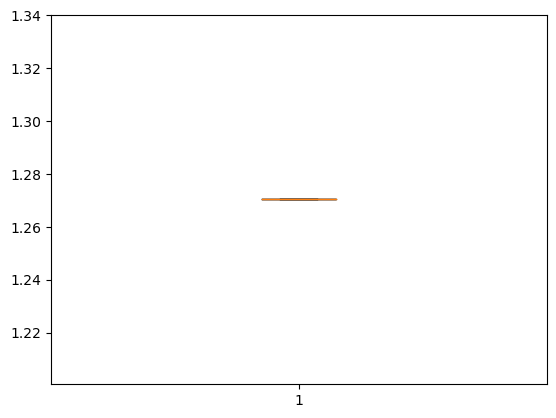

In [31]:
print("mean is ", np.mean(results), " and standard deviation is ", np.std(results))
plt.figure()
plt.boxplot(results)
plt.show()

### BONUS Task: Train the Neural Network with a different optimiser, eg. ADAM, and report the relevant metrics